# Heavy Hitter Performance Comparison

There are a wide variety of proposed solutions to the heavy hitters problem, ranging from [Poplar](https://eprint.iacr.org/2021/017.pdf) to [STAR](https://brave.com/research/files/star-ccs-2022.pdf). Conveniently, both Poplar and STAR can be viewed as a form of [VDAF](https://cfrg.github.io/draft-irtf-cfrg-vdaf/draft-irtf-cfrg-vdaf.html), or verifiable distributed aggregation function. A VDAF is a multi-party protocol between clients and one or more aggregators for computing aggregate statistics. The protocol consists of the following phases:
 
- Sharding: Computing input shares from an individual measurement. For convenience, we also refer to this phase as the Uploading phase.
- Preparation: Conversion and verification of input shares to output shares compatible with the aggregation function being computed.
- Aggregation: Combining a sequence of output shares into an aggregate share.
- Unsharding: Combining a sequence of aggregate shares into an aggregate result. For convenience, we also refer to this phase as the Finalization phase.

In this note, we seek to compare the performance of STAR and Poplar in reasonable application scenarios. Before doing so, we first provide a high-level overview of each variant in the VDAF framework. 

## STAR

The STAR protocol, described in [this draft specification](https://shivankaul.com/star-spec/draft-dss-star.html), can be mapped to a VDAF in the following way.

- Sharding/Uploading: Run the randomness phase of the protocol to boost the entropy of the client input measurement and send a report derived from this randomness output to the aggregator.
- Preparation: For variants of STAR that use verifiable secret sharing (VSS) to prevent corrupt reports, the aggregator locally runs the VSS share verification algorithm to filter out invalid reports.
- Aggregation: The aggregator locally runs the secret share recovery process using the report shares in a batch, where each batch is identified by a unique tag, to decrypt each report and recover the heavy hitter measurement and the per-client associated auxiliary information.
- Unsharding: This is a no-op.

STAR can be deployed in either a stream or batch mode. In stream mode, the STAR aggregator performs preparation upon report ingestion, discarding reports that fail verification and placing valid reports into buckets identified by their tags. The aggregation step then performs recover and decryption to reveal the heavy hitters and their associated auxiliary information.

In batch mode, the aggregator performs preparation and aggregation at the same time when a batch reaches the threshold. This variant has the benefit that only reports that contribute to threshold-sized batches are verified. However, unlike stream mode, it does not allow the aggregator to spread out the cost of verification.

## Poplar

The Poplar protocol, described in [this draft specification](https://cfrg.github.io/draft-irtf-cfrg-vdaf/draft-irtf-cfrg-vdaf.html#name-poplar1), is mapped to a VDAF in the following way.

- Sharding/Uploading: Clients split their measurement into shares for each aggregator and sends a report to the primary aggregator.
- Preparation: Aggregators run an interactive protocol with the collector for evaluating an iDPF.
- Aggregation: Aggregators locally combine output shares to yield aggregate shares.
- Unsharding: The collector locally combines aggregate shares to yield an aggregate result.

The preparation, aggregation, and unsharding phases are driven by the collector based on a set of candidate prefixes, starting from an empty set, where each sequence of phases yields a new candidate set of prefixes. As a result, this sequence of phases is run until the final heavy hitters are revealed. The number of times this sequence is run depends on the heavy hitter threshold, number of reports in a batch, and the length of each input string.

Poplar is oriented around batch processing, wherein client reports are processed in an aggregation job in batches. As such, processing a batch of reports requires invoking both the preparation and aggregation steps for the VDAF, as many times as needed to reveal the heavy hitter output.

# Aggregation Cost

The sections above discuss the cost of a single run of STAR and Poplar for collecting heavy hitters over a batch of client data. They fail to take the specifics of applications and data into account for the aggregation task. The distribution of heavy hitters amongst a set of client reports can influence how an application chooses to run each of the protocols, and therefore has an impact on the overall cost.

<!-- As an example, consider the best case scenario for Poplar, wherein the number of reports from clients matches the heavy hitter threshold, and each of the reports corresponds to the same heavy hitter value. In this case, a single run of Poplar would successfully reveal this heavy hitter to the application with minimal cost. Now consider the worst case scenario: where for a given set of reports, every possible value of heavy hitter appears $t-1$ times in the set, where $t$ is the threshold. In this case, Poplar would be maximally expensive.

To further complicate matters, Poplar is designed such that client reports can be used in at most one protocol run. This means applications need to make a tradeoff between cost and utility of the protocol. They could, for example, seek to maximize the client report batch size in order to increase the probability of collecting meaningful heavy hitters, although this approach would come at increased cost.  -->

In order to meaningfully compare STAR and Poplar, we need to consider the application cost and their measurement strategy. In practice, there are two common questions applications might seek to answer:

1. What are the heavy hitters shared by at least $t$ clients? This is referred to as an exploratory query.
2. Out of a set of candidate heavy hitters, are any of them shared by at least $t$ clients? This is referred to as a state query.

To compare STAR and Poplar, we'll use these two types of queries for varying application parameters. 

## Exploratory Query Cost

For this type of query, we parameterize a dataset by the following values:

1. Input heavy hitter string length ($N$);
2. Size of the set of possible input strings, i.e., the size of input heavy hitter domain ($D$);
3. Number of samples to draw from the set of input strings ($S$); and
4. Threshold value ($T$).

We consider four variants of heavy hitter protocols: batch STAR without VSS, stream STAR without VSS, batch STAR with VSS, stream STAR with VSS, and batch Poplar. We measure overall time-to-aggregate as a function of the application threshold size and the number of reports that contributed to a batch, referred to as the report sample size. For simplicity, we fix the length of input strengs $N$ to 32 bytes, and the size of possible input strings to $128$. (In other words, there is a set of $128$ random strings of length $32$ bytes, and the samples are drawn from this set with a Zipf distribution using parameter 1.03 and support $128$.)

The following code uses an open source implementation of [STAR](https://github.com/chris-wood/star-go) and [Poplar](https://github.com/henrycg/heavyhitters). Instructions to reproduce this data can be found [here](https://github.com/chris-wood/heavy-hitter-comparison/blob/main/README.md).

<IPython.core.display.Javascript object>


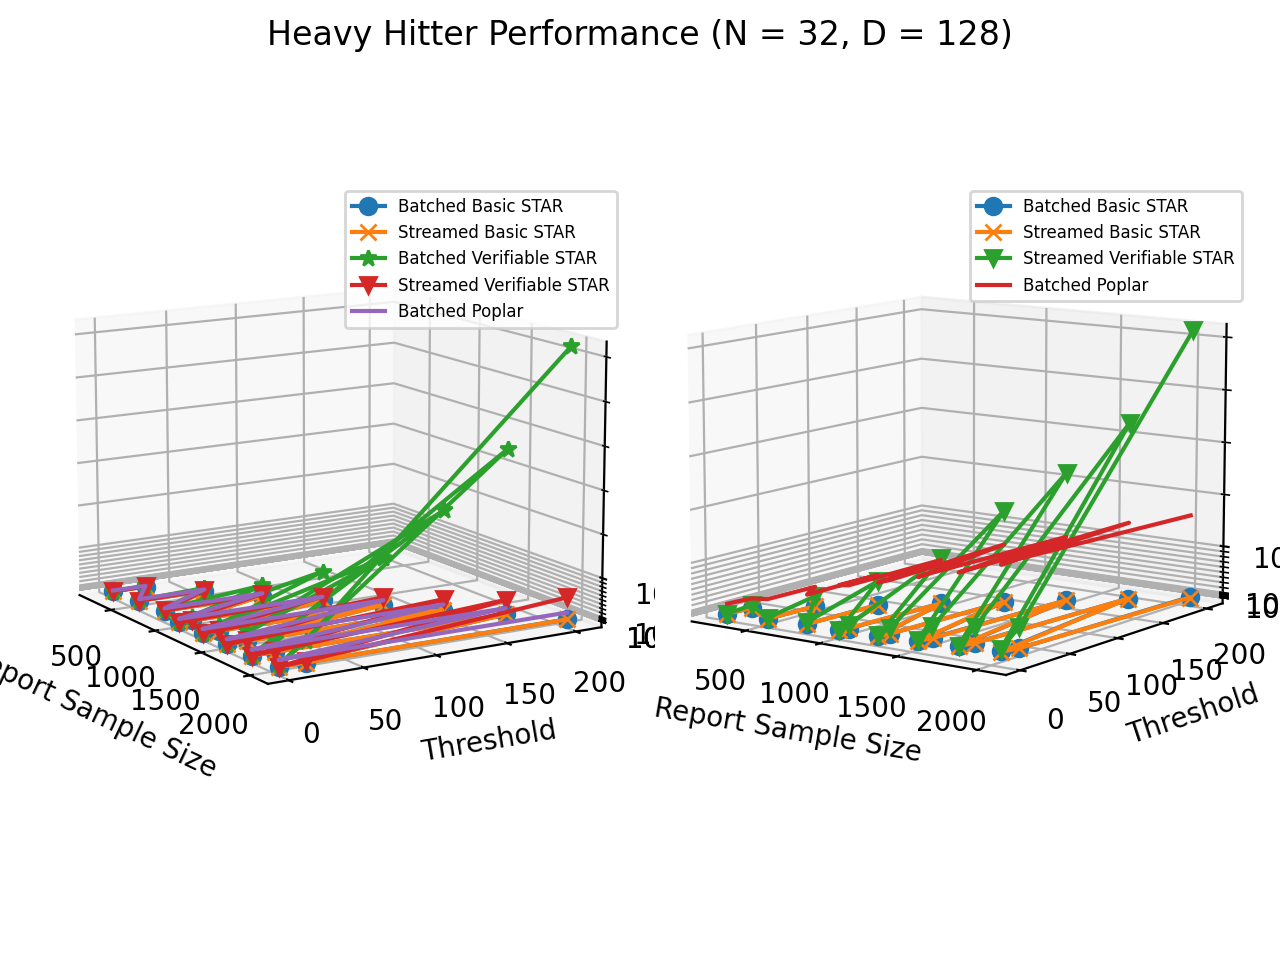

In [5]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.stats as stats

# python3 format_benchmarks.py < bench_out.txt
poplar_costs = [(256, 2, 0.203133549), (256, 25, 0.180319839), (512, 5, 0.387140073), (512, 51, 0.377604992), (768, 7, 0.57454212), (768, 76, 0.582117805), (1024, 1, 0.896490452), (1024, 10, 0.844757809), (1024, 102, 0.845759087), (1280, 1, 1.055162121), (1280, 12, 1.041503094), (1280, 128, 1.117525945), (1536, 1, 1.266680687), (1536, 15, 1.2723745819999999), (1536, 153, 1.244590463), (1792, 1, 1.457594364), (1792, 17, 1.45951553), (1792, 179, 1.4925589719999999), (2048, 2, 1.703727276), (2048, 20, 1.716849661), (2048, 204, 1.615453654)]
basic_batch_costs = [(256, 2, 0.011222094), (256, 25, 0.001331438), (512, 5, 0.016549084), (512, 51, 0.004437127), (768, 7, 0.027786562), (768, 76, 0.005354132), (1024, 1, 0.063778211), (1024, 10, 0.044180702), (1024, 102, 0.00927317), (1280, 1, 0.067786735), (1280, 12, 0.053228559), (1280, 128, 0.01314244), (1536, 1, 0.099943674), (1536, 15, 0.084787839), (1536, 153, 0.018514921), (1792, 1, 0.129389609), (1792, 17, 0.102282164), (1792, 179, 0.028976056), (2048, 2, 0.16085007), (2048, 20, 0.105485431), (2048, 204, 0.03641169)]
feldman_stream_costs = [(256, 2, 0.014019671), (256, 25, 0.04964061), (512, 5, 0.035880662), (512, 51, 0.198221144), (768, 7, 0.065912345), (768, 76, 0.46155146), (1024, 1, 0.061730434), (1024, 10, 0.110550343), (1024, 102, 0.875462118), (1280, 1, 0.090821935), (1280, 12, 0.159897019), (1280, 128, 1.767564536), (1536, 1, 0.123954574), (1536, 15, 0.291269619), (1536, 153, 2.472443977), (1792, 1, 0.14582753), (1792, 17, 0.383562694), (1792, 179, 3.40575377), (2048, 2, 0.199552243), (2048, 20, 0.489898674), (2048, 204, 5.139891788)]
basic_stream_costs = [(256, 2, 0.010861459), (256, 25, 0.00129841), (512, 5, 0.016391289), (512, 51, 0.004432831), (768, 7, 0.026522217), (768, 76, 0.005377433), (1024, 1, 0.067668325), (1024, 10, 0.047909696), (1024, 102, 0.0092547), (1280, 1, 0.070926322), (1280, 12, 0.053669052), (1280, 128, 0.012106653), (1536, 1, 0.107336233), (1536, 15, 0.077931575), (1536, 153, 0.018821248), (1792, 1, 0.137493747), (1792, 17, 0.098389804), (1792, 179, 0.02891637), (2048, 2, 0.148165657), (2048, 20, 0.107855308), (2048, 204, 0.026321342)]
feldman_batch_costs = [(256, 2, 0.048935717), (256, 25, 0.156743429), (512, 5, 0.180460616), (512, 51, 0.725009394), (768, 7, 0.396675824), (768, 76, 2.470820064), (1024, 1, 0.146228519), (1024, 10, 0.763060616), (1024, 102, 6.792259446), (1280, 1, 0.189893764), (1280, 12, 1.268122743), (1280, 128, 11.015628261), (1536, 1, 0.267693944), (1536, 15, 2.260490513), (1536, 153, 23.087483655), (1792, 1, 0.358762865), (1792, 17, 2.901591905), (1792, 179, 38.027417621), (2048, 2, 0.598014685), (2048, 20, 4.86053223), (2048, 204, 62.105174406)]

fig = plt.figure(layout="constrained")

def add_plot(ax, costs, label, marker):
    X = np.array(list(map(lambda t : t[0], costs)))
    Y = np.array(list(map(lambda t : t[1], costs)))
    Z = np.array(list(map(lambda t : t[2], costs)))
    ax.plot(X, Y, Z, marker=marker, label=label)

# First plot with all three
ax = fig.add_subplot(1, 2, 1, projection='3d')
    
add_plot(ax, basic_batch_costs, "Batched Basic STAR", 'o')
add_plot(ax, basic_stream_costs, "Streamed Basic STAR", 'x')
add_plot(ax, feldman_batch_costs, "Batched Verifiable STAR", '*')
add_plot(ax, feldman_stream_costs, "Streamed Verifiable STAR", 'v')
add_plot(ax, poplar_costs, "Batched Poplar", '')

ax.set_xlabel("Report Sample Size")
ax.set_ylabel("Threshold")
ax.set_zlabel("Time (s)")
ax.set_zscale('log')
ax.legend(fontsize=6)

# Second plot with basic STAR and Poplar
ax = fig.add_subplot(1, 2, 2, projection='3d')
    
add_plot(ax, basic_batch_costs, "Batched Basic STAR", 'o')
add_plot(ax, basic_stream_costs, "Streamed Basic STAR", 'x')
add_plot(ax, feldman_stream_costs, "Streamed Verifiable STAR", 'v')
add_plot(ax, poplar_costs, "Batched Poplar", '')

ax.set_xlabel("Report Sample Size")
ax.set_ylabel("Threshold")
ax.set_zlabel("Time (s)")
ax.set_zscale('log')
ax.legend(fontsize=6)

fig.tight_layout()
fig.suptitle("Heavy Hitter Performance (N = 32, D = 128)")
plt.show()